In [3]:
import scanpy
import pandas as pd
import numpy as np
from kneed import KneeLocator

### Performing basic preprocessing of scRNA-seq data

In [4]:
adata = scanpy.read(filename = "scRNA-seq_rna_umap.h5ad")

In [5]:
# following contacttracing tutorial
adata.obs.index.name=None
adata.var.index.name=None

In [6]:
# making sure cell barcodes are unique
numdup = sum(adata.obs.index.duplicated())
print(f'{numdup} duplicated barcodes')
if numdup > 0:
    adata.obs_names_make_unique()
    numdup = sum(adata.obs.index.duplicated())
    print(f'Now, {numdup} duplicated barcodes')

0 duplicated barcodes


In [7]:
# condition setting
adata.obs['Condition'] = adata.obs['Sample']

In [8]:
adata.obs['cell type'] = adata.obs['new_annotation']

In [9]:
adata.obs['Condition'].value_counts()

Condition
aPD1_aCTLA4    2939
Control        2607
Name: count, dtype: int64

In [10]:
# removing small cell types
minCell = 50
ctcounts = adata.obs[['cell type','Condition']].value_counts()
remove_cellTypes = ctcounts[ctcounts < minCell].reset_index()['cell type'].unique()
if len(remove_cellTypes) > 0:
    tmpstr = ','.join(remove_cellTypes)
    print(f'Removing celltypes: {tmpstr}')
    print(f'Original ncell {adata.shape[0]}')
    adata = adata[~adata.obs['cell type'].isin(remove_cellTypes)]
    print(f'New ncell {adata.shape[0]}')
else:
    print('Keeping all cell types')

Keeping all cell types


In [11]:
# creating logX layer
adata.X = adata.X.toarray()
adata.layers['logX'] = np.log10(adata.X + 0.1) - np.log10(0.1)

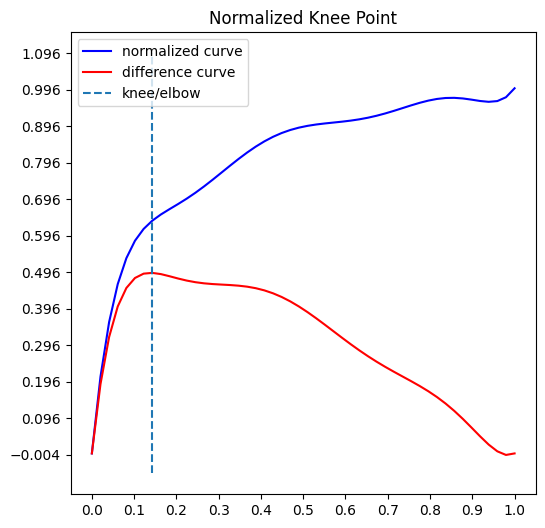

In [12]:

# use kneepoint method to get number of PCs to use
init_npcs = 50
scanpy.pp.pca(adata, n_comps=init_npcs)
x = [x for x in range(len(adata.uns['pca']['variance_ratio']))]
y = np.log(adata.uns['pca']['variance_ratio'])
knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
knee.plot_knee_normalized()

In [13]:
opt_n_pcs = knee.knee+1
print('Optimal Number of PCs: ', str(opt_n_pcs))
scanpy.pp.pca(adata, n_comps=opt_n_pcs)
scanpy.pp.neighbors(adata)
scanpy.tl.umap(adata)

Optimal Number of PCs:  8


/Users/nicholasdjedjos/.pyenv/versions/3.9.7/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


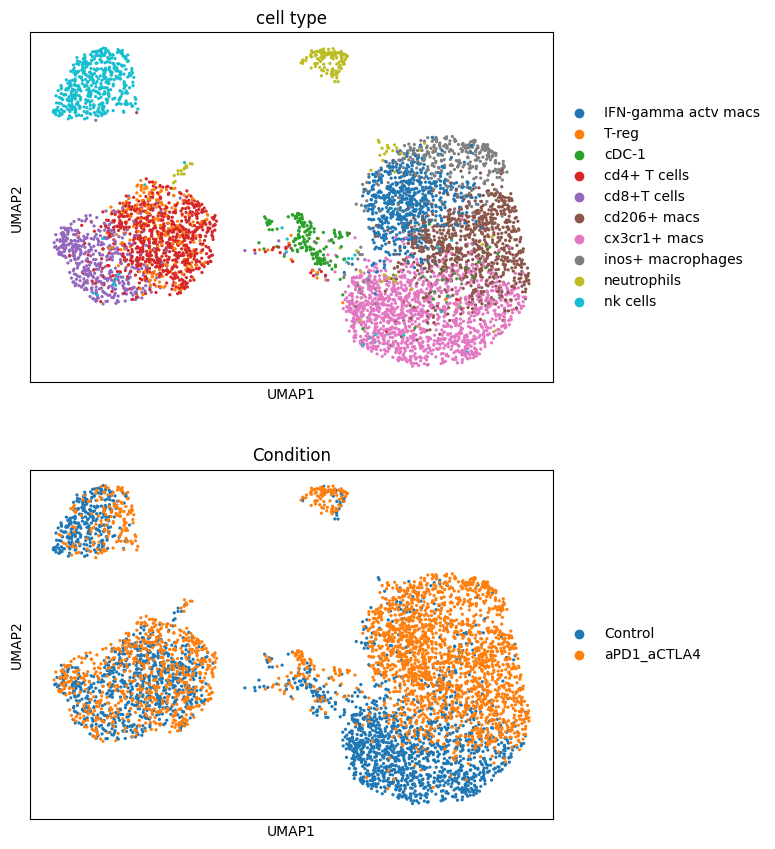

In [15]:
scanpy.pl.umap(adata, color=['cell type', 'Condition'], ncols=1)
